# Load Library

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from attack_utils import get_CSMIA_case_by_case_results, CSMIA_attack, LOMIA_attack, get_LOMIA_results
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from experiment_utils import MIAExperiment, get_perf
from disparity_inference_utils import get_confidence_array, draw_confidence_array_scatter, get_indices_by_group_condition, get_corr_btn_sens_and_out_per_subgroup, get_slopes, get_angular_difference, calculate_stds, get_mutual_info_btn_sens_and_out_per_subgroup
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
import copy
from scipy.stats import kendalltau, spearmanr

import matplotlib as mpl

# Load Dataset

In [4]:
experiments = {}
for i in range(1):
    experiment = MIAExperiment(sampling_condition_dict = 
        {
                'subgroup_col_name': 'ST',
                'n': 1000,
        }, random_state = i,
        shortname = f"Corr_btn_sens_and_output_for_ST_ranging_from_0_to_-0.5_random_state_{i}"
    )
    experiments[experiment.shortname] = experiment

In [6]:
subgroup_vals = [1, 2, 3, 4, 6, 20, 50, 51, 62, 63]
experiment_texas = MIAExperiment(sampling_condition_dict = 
    {
            'subgroup_col_name': 'PAT_STATUS',
            'subgroup_values': subgroup_vals,
            # 'subgroup_values': ['1', '2', '3', '4', '6', '20', '50', '51', '62', '63'],
            'n': 5000
    }, shortname = f"Corr_btn_sens_and_output_for_PAT_STATUS_ranging_from_0_to_-0.5", name='Texas100', sensitive_column='SEX_CODE'
)

# Train/Load Model

In [12]:
save_model = True

print(f"Training classifier for experiment: {experiment}")
try:
    experiment.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')
    print(f"Loaded classifier for experiment from file: {experiment}")
except:
    # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
    experiment.clf = model_utils.get_model(max_iter=500)
    experiment.clf.fit(experiment.X_train, experiment.y_tr_onehot)

    if save_model:
        model_utils.save_model(experiment.clf, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')

Training classifier for experiment: Census19_subgroup_col_name_ST_n_1000_rs0
Loaded classifier for experiment from file: Census19_subgroup_col_name_ST_n_1000_rs0


In [13]:
save_model = True

print(f"Training classifier for experiment: {experiment_texas}")
try:
    experiment_texas.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment_texas.ds.ds.filenameroot}_target_model.pkl')
    print(f"Loaded classifier for experiment from file: {experiment_texas}")
except:
    # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
    experiment_texas.clf = model_utils.get_model(max_iter=500)
    experiment_texas.clf.fit(experiment_texas.X_train, experiment_texas.y_tr_onehot)

    if save_model:
        model_utils.save_model(experiment_texas.clf, f'<PATH_TO_MODEL>/{experiment_texas.ds.ds.filenameroot}_target_model.pkl')

Training classifier for experiment: Texas100_subgroup_col_name_PAT_STATUS_subgroup_values_[1, 2, 3, 4, 6, 20, 50, 51, 62, 63]_n_5000_rs42
Loaded classifier for experiment from file: Texas100_subgroup_col_name_PAT_STATUS_subgroup_values_[1, 2, 3, 4, 6, 20, 50, 51, 62, 63]_n_5000_rs42


# Compute Angular Difference and Evaluate Attribute Inference Attack for Each Group

In [14]:
def get_group_by_group_evaluation(experiment, subgroup_col_name='ST', subgroup_vals=[]):
    experiment.confidence_array = get_confidence_array(experiment, experiment.X_train, experiment.y_tr, experiment.clf)
    sens_pred, case_indices = CSMIA_attack(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
    case_2_indices = case_indices[2]
    experiment.confidence_array_case_2 = experiment.confidence_array[case_2_indices, :]
    experiment.X_case_2 = experiment.X_train.loc[case_2_indices].copy().reset_index(drop=True)
    experiment.y_case_2 = experiment.y_tr.ravel()[case_2_indices]
    experiment.sens_pred_CSMIA = sens_pred
    experiment.sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)

    conditions = [{}] + [{subgroup_col_name: i} for i in subgroup_vals]
    # num_of_samples_per_group_in_aux = 100 if experiment.ds.ds.name == 'Census19' else 500
    aux_indices = np.concatenate([get_indices_by_group_condition(experiment.X_test, condition).to_series().sample(frac=0.02, random_state=42, replace=False).index for condition in conditions[1:]])
    X_aux, y_aux = experiment.X_test.copy().loc[aux_indices].reset_index(drop=True), experiment.y_te[aux_indices]
    sub_size_df = get_CSMIA_case_by_case_results(experiment.clf, X_aux, y_aux, experiment.ds, subgroup_col_name, metric='accuracy', sensitive_col_name=None, subgroup_vals=subgroup_vals)
    baseline_res = sub_size_df.loc['Case All Cases'].to_numpy()
    baseline_res = np.array([baseline_res[-1]]+[get_perf(r) for r in baseline_res[:-1]])

    experiment.y_te_pred = experiment.clf.predict(experiment.X_test)[:,1]

    correlation_vs_ang_diff = {}
    for i, condition in enumerate(conditions):
        fcondition = f'{condition}'
        correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, condition)
        indices = get_indices_by_group_condition(experiment.X_case_2, condition)
        angular_difference = get_angular_difference(experiment, experiment.confidence_array_case_2[indices], experiment.y_case_2[indices])
        correlation_vs_ang_diff[fcondition] = {}
        correlation_vs_ang_diff[fcondition]['correlation'] = correlation
        correlation_vs_ang_diff[fcondition]['angular_difference'] = -angular_difference
        indices = get_indices_by_group_condition(experiment.X_train, condition)
        correlation_vs_ang_diff[fcondition]['CSMIA_attack_accuracy'] = 100 * accuracy_score(experiment.sens_val_ground_truth[indices], experiment.sens_pred_CSMIA[indices])
        correlation_vs_ang_diff[fcondition]['LOMIA_attack_accuracy'] = 100 * accuracy_score(experiment.sens_val_ground_truth[indices], experiment.sens_pred_LOMIA[indices])
        indices_2 = get_indices_by_group_condition(experiment.X_test, condition)
        correlation_vs_ang_diff[fcondition]['model_accuracy'] = 100 * accuracy_score(experiment.y_te[indices_2].ravel(), experiment.y_te_pred[indices_2])
        correlation_vs_ang_diff[fcondition]['baseline_attack_accuracy'] = baseline_res[i]

    correlation_vs_ang_diff_df = pd.DataFrame.from_dict(correlation_vs_ang_diff, orient='index')

    return correlation_vs_ang_diff_df



In [15]:
correlation_vs_ang_diff_df = get_group_by_group_evaluation(experiment, subgroup_col_name='ST', subgroup_vals=list(range(51)))

In [16]:
correlation_vs_ang_diff_df_texas = get_group_by_group_evaluation(experiment_texas, subgroup_col_name='PAT_STATUS', subgroup_vals=subgroup_vals)

# Plot Results

In [17]:
def scatter_plot(correlation_vs_ang_diff_df, x_axis, y_axis, fontsize=16):
    arr = correlation_vs_ang_diff_df[[x_axis['name'], y_axis['name']]].to_numpy()
    x_values, y_values = arr[:, 0], arr[:, 1]

    # Creating the scatter plot
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.scatter(x_values, y_values, color='black', alpha=0.75, marker='x', s=75)
    # plt.title('Scatter Plot of Correlation vs Angular Difference')
    plt.xlabel(x_axis['label'], fontsize=fontsize)
    plt.ylabel(y_axis['label'], fontsize=fontsize)
    ax.set_xticks(x_axis['xticks'])
    ax.set_xticklabels([f'{i:.1f}' for i in x_axis['xticks']], fontsize=fontsize)
    ax.set_yticks(y_axis['yticks'])
    ax.set_yticklabels([f'{i:.0f}%' for i in y_axis['yticks']], fontsize=fontsize)
    # plt.xlim(-0.5, 0.025)
    plt.grid(True, linewidth=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # sns.despine()
    plt.show()

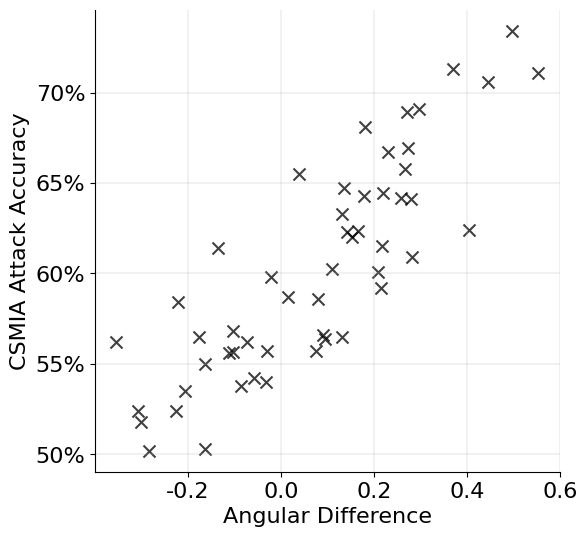

In [18]:
scatter_plot(
    correlation_vs_ang_diff_df,
    x_axis={'name': 'angular_difference', 'label': 'Angular Difference', 'xticks': np.arange(-0.2, 0.7, 0.2)},
    y_axis={'name': 'CSMIA_attack_accuracy', 'label': 'CSMIA Attack Accuracy', 'yticks': np.arange(50, 75, 5)}
    )

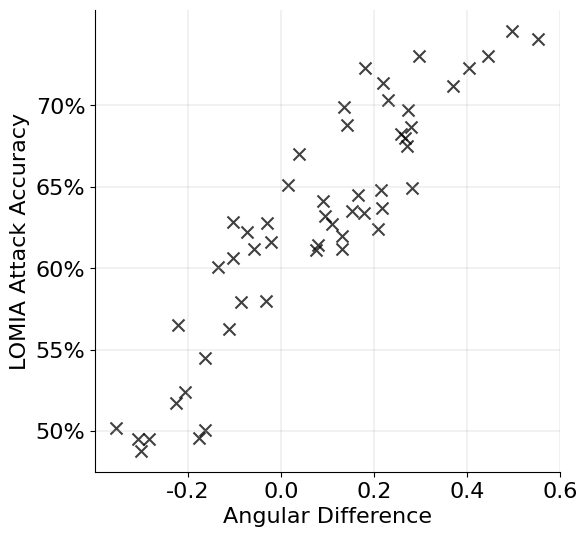

In [19]:
scatter_plot(
    correlation_vs_ang_diff_df,
    x_axis={'name': 'angular_difference', 'label': 'Angular Difference', 'xticks': np.arange(-0.2, 0.7, 0.2)},
    y_axis={'name': 'LOMIA_attack_accuracy', 'label': 'LOMIA Attack Accuracy', 'yticks': np.arange(50, 75, 5)}
    )

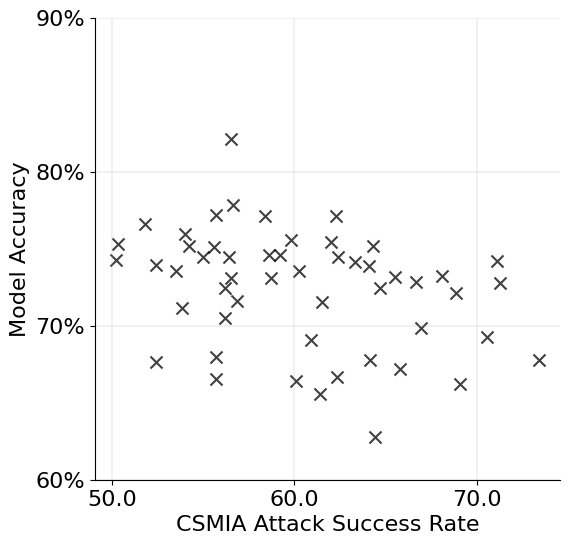

In [20]:
scatter_plot(
    correlation_vs_ang_diff_df,
    x_axis={'name': 'CSMIA_attack_accuracy', 'label': 'CSMIA Attack Success Rate', 'xticks': np.arange(50, 80, 10)},
    y_axis={'name': 'model_accuracy', 'label': 'Model Accuracy', 'yticks': np.arange(60, 100, 10)}
    )

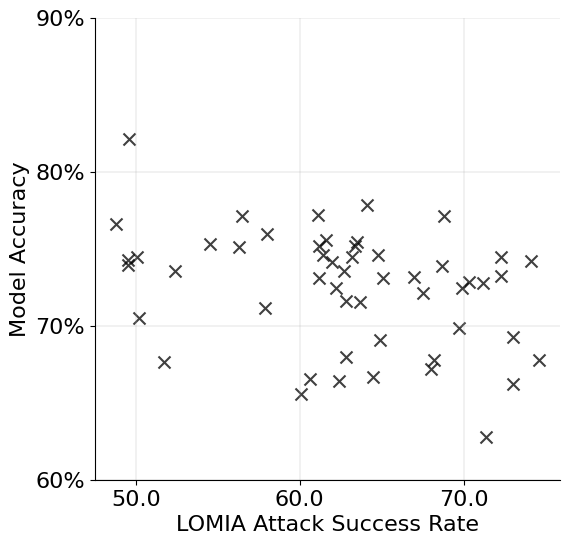

In [21]:
scatter_plot(
    correlation_vs_ang_diff_df,
    x_axis={'name': 'LOMIA_attack_accuracy', 'label': 'LOMIA Attack Success Rate', 'xticks': np.arange(50, 80, 10)},
    y_axis={'name': 'model_accuracy', 'label': 'Model Accuracy', 'yticks': np.arange(60, 100, 10)}
    )

# Compute Ranking Quality of Disparity Inference Attack

In [26]:
def get_ranking_quality(correlation_vs_ang_diff_df):
    attacks = ['CSMIA', 'LOMIA']
    metrics = [kendalltau, spearmanr]
    metric_name_dict = {
        kendalltau: 'Kendall Tau',
        spearmanr: 'Spearman R'
    }

    ranking_perf_dict = {}
    for attack in attacks:
        ranking_perf_dict[attack] = {}
        for metric in metrics:
            ranking_perf_dict[attack][metric_name_dict[metric]] = {}

            attack_name_dict = {'angular_difference': 'Disparity Inference', 'baseline_attack_accuracy': 'Baseline Attack'}
            for dia in ['angular_difference', 'baseline_attack_accuracy']:
                ranking_perf = metric(correlation_vs_ang_diff_df[[f'{attack}_attack_accuracy']].to_numpy(), correlation_vs_ang_diff_df[[dia]].to_numpy())
                ranking_perf_dict[attack][metric_name_dict[metric]][attack_name_dict[dia]] = f'{round(ranking_perf.statistic, 4)} ({ranking_perf.pvalue:.2e})'

    return ranking_perf_dict

In [33]:
print(experiment.name)
res_dict = get_ranking_quality(correlation_vs_ang_diff_df)
print('\nCSMIA\n')
print(tabulate.tabulate(pd.DataFrame.from_dict(res_dict['CSMIA'], orient='index').T, headers='keys', tablefmt='fancy_grid'))
print('\nLOMIA\n')
print(tabulate.tabulate(pd.DataFrame.from_dict(res_dict['LOMIA'], orient='index').T, headers='keys', tablefmt='fancy_grid'))

Census19

CSMIA

╒═════════════════════╤═══════════════════╤═══════════════════╕
│                     │ Kendall Tau       │ Spearman R        │
╞═════════════════════╪═══════════════════╪═══════════════════╡
│ Disparity Inference │ 0.6742 (1.82e-12) │ 0.8588 (3.86e-16) │
├─────────────────────┼───────────────────┼───────────────────┤
│ Baseline Attack     │ 0.0275 (7.76e-01) │ 0.0372 (7.93e-01) │
╘═════════════════════╧═══════════════════╧═══════════════════╛

LOMIA

╒═════════════════════╤═══════════════════╤═══════════════════╕
│                     │ Kendall Tau       │ Spearman R        │
╞═════════════════════╪═══════════════════╪═══════════════════╡
│ Disparity Inference │ 0.7462 (6.32e-15) │ 0.9095 (1.06e-20) │
├─────────────────────┼───────────────────┼───────────────────┤
│ Baseline Attack     │ 0.0711 (4.62e-01) │ 0.0988 (4.86e-01) │
╘═════════════════════╧═══════════════════╧═══════════════════╛


In [35]:
print(experiment_texas.name)
res_dict_texas = get_ranking_quality(correlation_vs_ang_diff_df_texas)
print('\nCSMIA\n')
print(tabulate.tabulate(pd.DataFrame.from_dict(res_dict_texas['CSMIA'], orient='index').T, headers='keys', tablefmt='fancy_grid'))
print('\nLOMIA\n')
print(tabulate.tabulate(pd.DataFrame.from_dict(res_dict_texas['LOMIA'], orient='index').T, headers='keys', tablefmt='fancy_grid'))

Texas100

CSMIA

╒═════════════════════╤════════════════════╤════════════════════╕
│                     │ Kendall Tau        │ Spearman R         │
╞═════════════════════╪════════════════════╪════════════════════╡
│ Disparity Inference │ -0.6364 (5.71e-03) │ -0.7818 (4.47e-03) │
├─────────────────────┼────────────────────┼────────────────────┤
│ Baseline Attack     │ -0.2569 (2.74e-01) │ -0.4146 (2.05e-01) │
╘═════════════════════╧════════════════════╧════════════════════╛

LOMIA

╒═════════════════════╤════════════════════╤════════════════════╕
│                     │ Kendall Tau        │ Spearman R         │
╞═════════════════════╪════════════════════╪════════════════════╡
│ Disparity Inference │ -0.6 (9.95e-03)    │ -0.7636 (6.23e-03) │
├─────────────────────┼────────────────────┼────────────────────┤
│ Baseline Attack     │ -0.1468 (5.32e-01) │ -0.3052 (3.61e-01) │
╘═════════════════════╧════════════════════╧════════════════════╛
